###########################################################################<br>
\# This code is associated to the paper:<br>
\# <b>Provable bounds for noise-free expectation values computed from noisy samples</b><br>
\# (https://arxiv.org/abs/2312.00733)<br>
\# <br>
\# (C) Copyright IBM 2024.<br>
\# <br>
\# Any modifications or derivative works of this code must retain<br>
\# this copyright notice, and modified files need to carry a notice<br>
\# indicating that they have been altered from the originals.<br>
###########################################################################

# Fidelity Estimation (50 qubits)

Fidelity estimation for the ZZ Feature Map presented in https://arxiv.org/abs/2312.00733.

This notebook contains the code for:
- [Figure 2](#Figure-2)
- [Figure 3](#Figure-3)

The initial layout, layer fidelity and error per layered gate (EPLG) can be estimated using this code:

https://github.com/qiskit-community/qiskit-device-benchmarking/blob/main/notebooks/layer_fidelity.ipynb

In [1]:
import os
from zipfile import ZipFile
from tqdm import tqdm
import json
import numpy as np
from scipy.optimize import fmin_slsqp, fminbound
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import BackendSamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer.primitives import SamplerV2 as AerSamplerV2
from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2, Batch

import mthree

In [2]:
def unzip_and_load_results_file(filename):
    
    # unzip file
    if not os.path.isfile(f'results/{filename}'):
        print(f'unzip {filename}.zip... ', end='')
        with ZipFile(f'results/{filename}.zip', 'r') as zf:
            zf.extractall(path='results/')
            print('done!')

    # load file
    print(f'load  {filename}...     ', end='')
    with open(f'results/{filename}', 'r') as f:
        data = json.load(f)
    print('done!')
    return data

In [3]:
# instantiate a sampler with matrix product state simulator
simulator = AerSimulator(method='matrix_product_state')
sim_sampler = BackendSamplerV2(backend=simulator)

In [4]:
# instantiate quantum backend
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_sherbrooke")

In [5]:
# set number of qubits
num_qubits = 50

# define feature maps to compute |<psi(x1)|psi(x2)>|^2
qc_fm_1 = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement='pairwise', insert_barriers=True)
qc_fm_2 = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement='pairwise', insert_barriers=True)

In [6]:
# set random seed for reproducibility
np.random.seed(42)

# sample random parameters
x = np.random.rand(qc_fm_1.num_parameters)
y = np.random.rand(qc_fm_1.num_parameters)
print('x =\n', x)
print('y =\n', y)

x =
 [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643
 0.43194502 0.29122914 0.61185289 0.13949386 0.29214465 0.36636184
 0.45606998 0.78517596 0.19967378 0.51423444 0.59241457 0.04645041
 0.60754485 0.17052412 0.06505159 0.94888554 0.96563203 0.80839735
 0.30461377 0.09767211 0.68423303 0.44015249 0.12203823 0.49517691
 0.03438852 0.9093204  0.25877998 0.66252228 0.31171108 0.52006802
 0.54671028 0.18485446]
y =
 [0.96958463 0.77513282 0.93949894 0.89482735 0.59789998 0.92187424
 0.0884925  0.19598286 0.04522729 0.32533033 0.38867729 0.27134903
 0.82873751 0.35675333 0.28093451 0.54269608 0.14092422 0.80219698
 0.07455064 0.98688694 0.77224477 0.19871568 0.00552212 0.81546143
 0.70685734 0.72900717 0.77127035 0.07404465 0.35846573 0.11586906
 0.86310343 0.62329813 0.33089802 0.06355835 0.31098232 0.32518332
 0.72960618 0.63755747 0.887

In [7]:
# define range of delta values for z = x + delta * y
deltas = np.linspace(-0.15, 0.15, 61)
deltas

array([-0.15 , -0.145, -0.14 , -0.135, -0.13 , -0.125, -0.12 , -0.115,
       -0.11 , -0.105, -0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075,
       -0.07 , -0.065, -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035,
       -0.03 , -0.025, -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,
        0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,
        0.05 ,  0.055,  0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,
        0.09 ,  0.095,  0.1  ,  0.105,  0.11 ,  0.115,  0.12 ,  0.125,
        0.13 ,  0.135,  0.14 ,  0.145,  0.15 ])

In [8]:
sim_shots = 10_000

In [9]:
# use matrix product state simlator to evaluate noise-free results
values = []
qcs = []

# construct |<psi(x)|psi(z)>|^2 circuits
for delta in tqdm(deltas):
    z = x + delta*y
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_fm_1.assign_parameters(x), range(num_qubits))
    qc.barrier()
    qc.append(qc_fm_2.assign_parameters(z).inverse(), range(num_qubits))
    qc.measure_all()
    qcs += [qc]

    job = sim_sampler.run([qc.decompose(reps=2)], shots=sim_shots)
    value = job.result()[0].data.meas.get_counts().get('0'*num_qubits, 0) / sim_shots
    values += [value]

# construct |<psi(z)|psi(x)>|^2 circuits (x, z reversed)
for delta in tqdm(deltas):
    z = x + delta*y
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_fm_1.assign_parameters(z), range(num_qubits))
    qc.barrier()
    qc.append(qc_fm_2.assign_parameters(x).inverse(), range(num_qubits))
    qc.measure_all()
    qcs += [qc]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 91.03it/s]


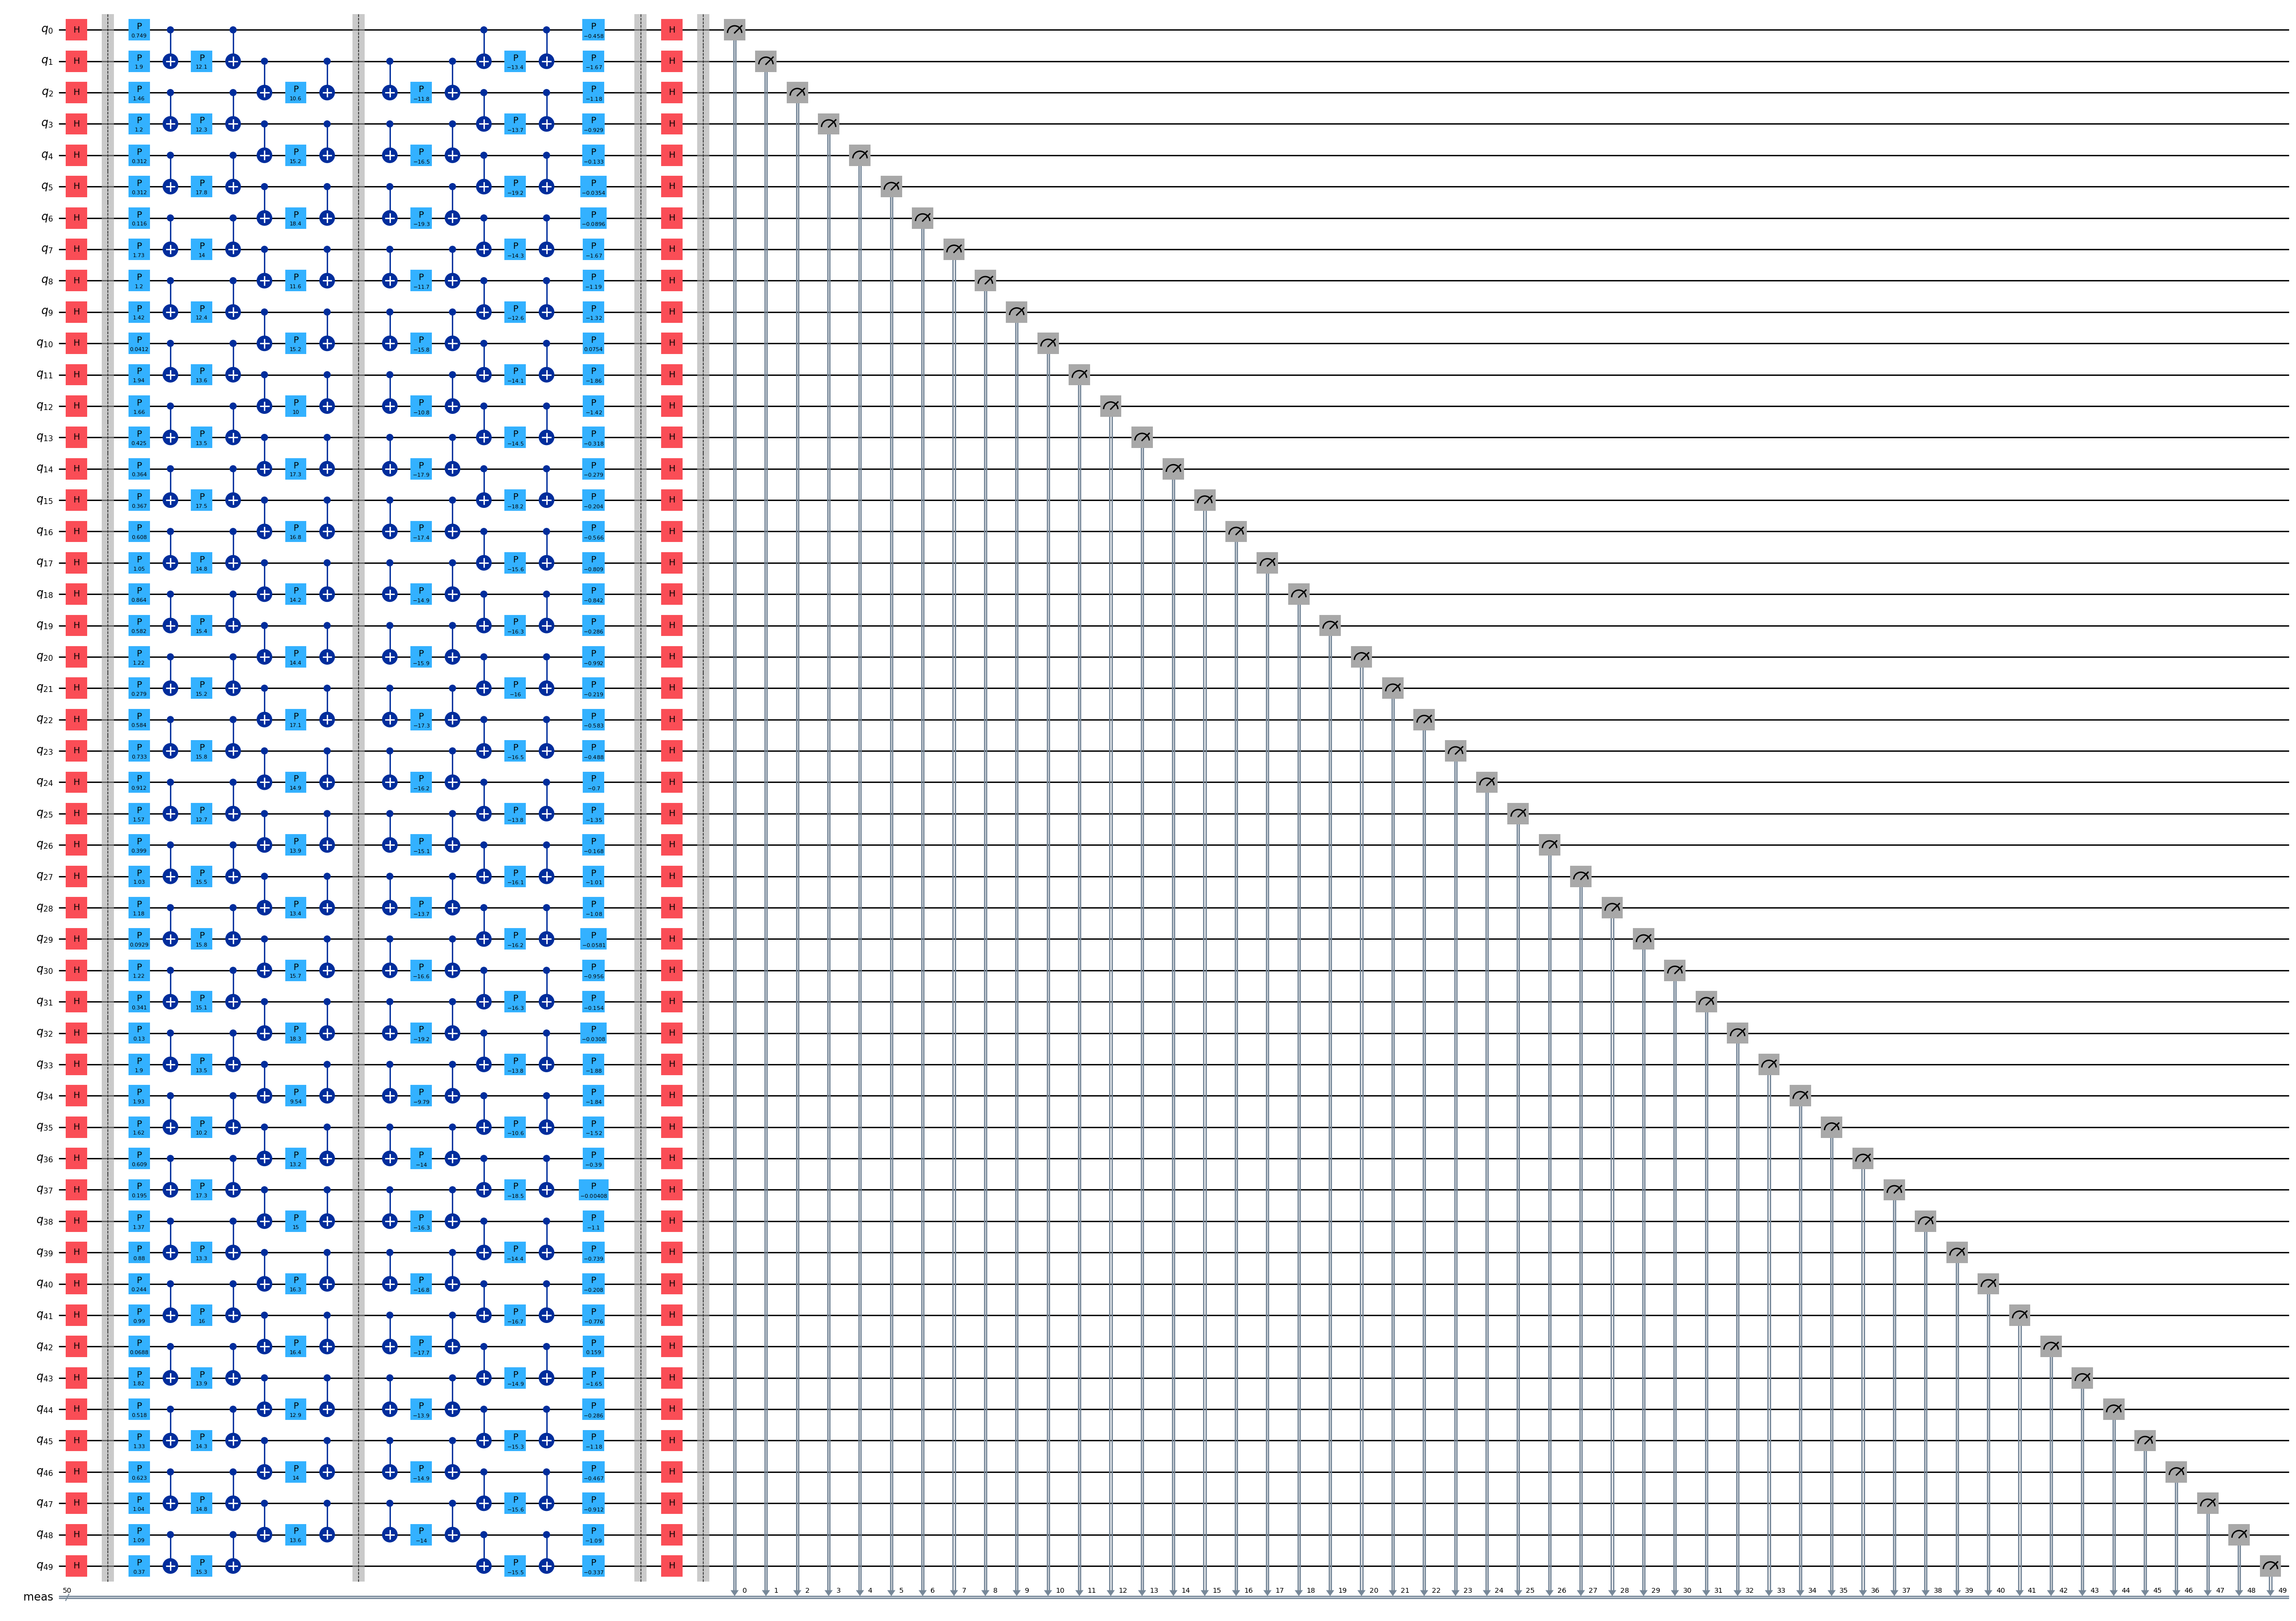

In [10]:
# draw circuit
qcs[0].decompose(reps=2).draw(output='mpl', fold=-1)

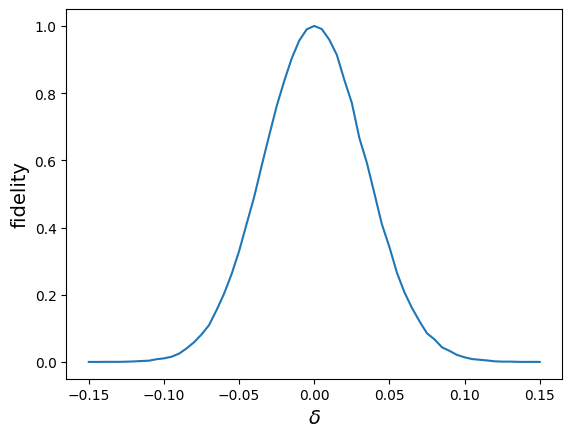

In [11]:
# plot noise-free results
plt.plot(deltas, values)
plt.xlabel(r'$\delta$', fontsize=14)
plt.ylabel(r'fidelity', fontsize=14)
plt.show()

In [12]:
##########################################################################################
# insert initial layout from layer fidelity experiments
initial_layout = [  8,   9,  10,  11,  12,  17,  30,  31,  32,  36,  51,  50,  49,
        48,  47,  35,  28,  27,  26,  25,  24,  34,  43,  44,  45,  54,
        64,  65,  66,  73,  85,  84,  83,  92, 102, 101, 100, 110, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 112, 108, 107]
##########################################################################################

In [13]:
# transpile circuits to backend
preset_manager = generate_preset_pass_manager(backend=backend, optimization_level=0, 
                                              initial_layout=initial_layout)
transpiled_qcs = preset_manager.run(qcs)    

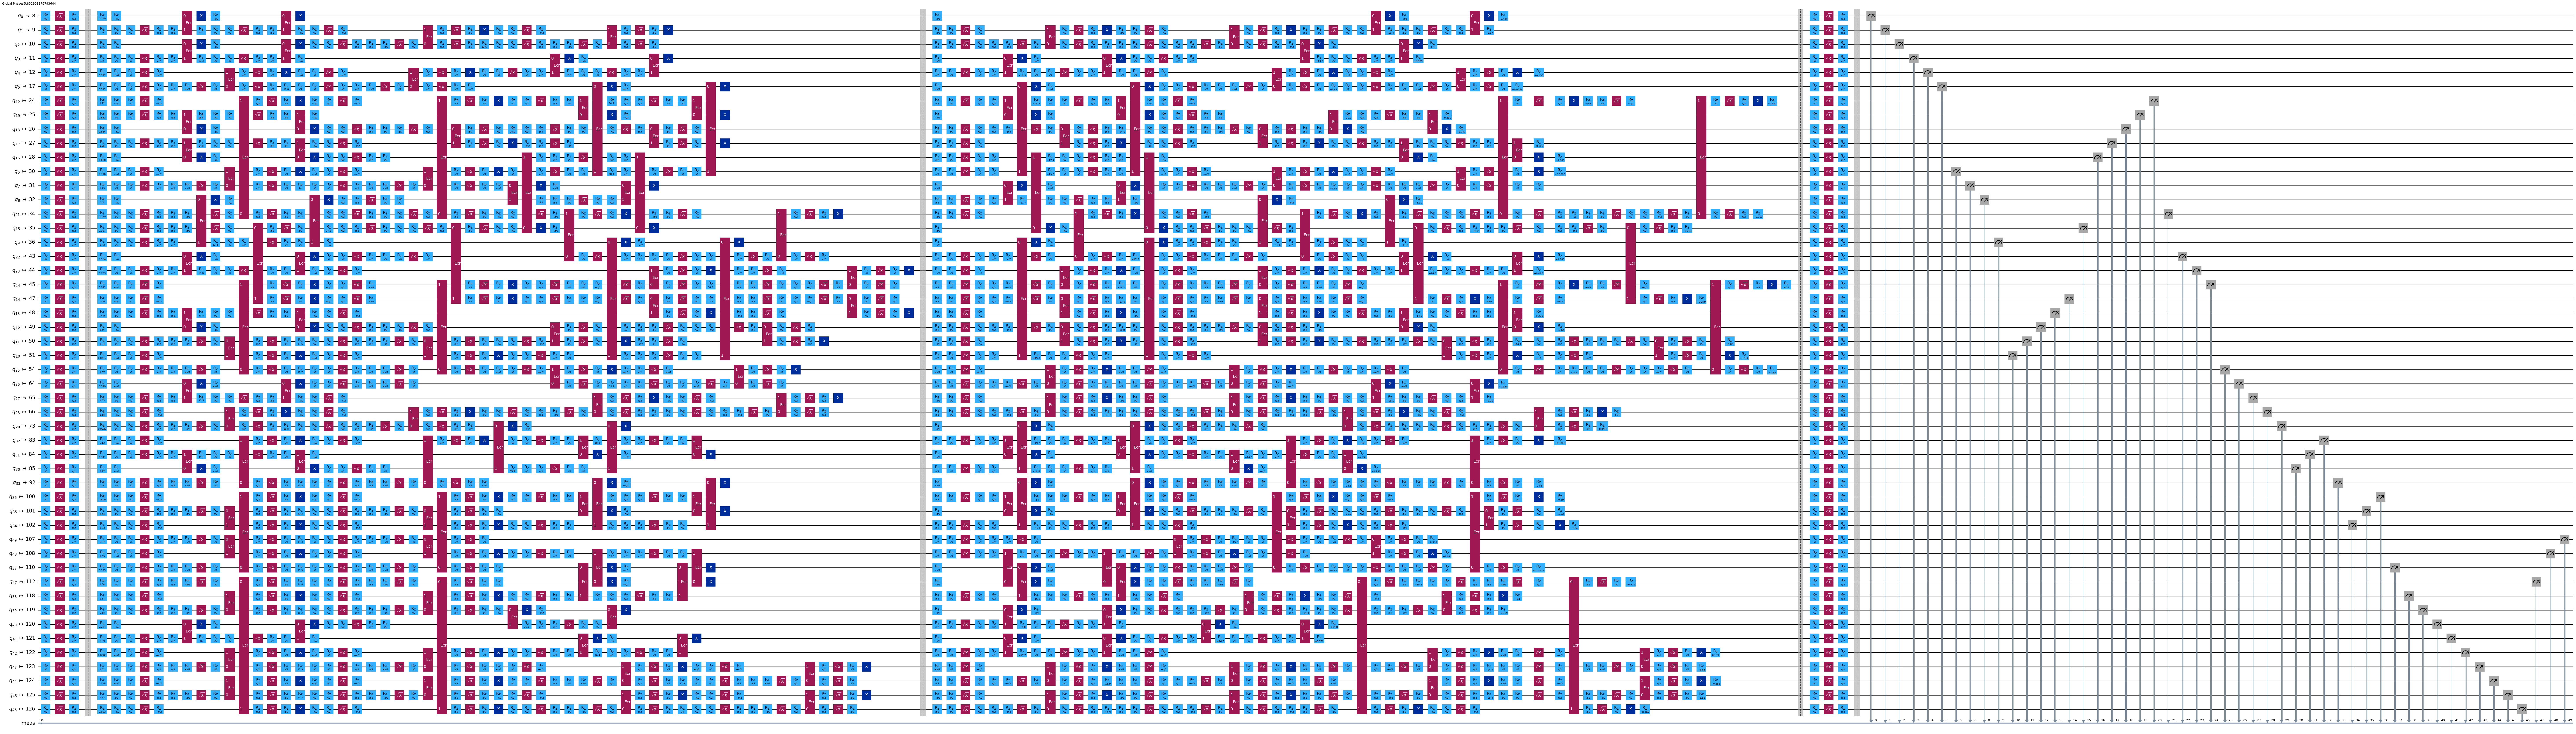

In [14]:
# draw transpiled circuit
transpiled_qcs[0].draw(output='mpl', fold=-1, idle_wires=False)

In [15]:
# print number of operations in circuit
print('number of circuits:', len(transpiled_qcs))
transpiled_qcs[0].count_ops()

number of circuits: 122


OrderedDict([('rz', 2178),
             ('sx', 696),
             ('ecr', 196),
             ('x', 196),
             ('measure', 50),
             ('barrier', 4)])

In [16]:
# uncomment to run circuits, otherwise, precomputed data will be loaded
# note that this will also overwrite the M3 measurement error calibrations
run_circuits = False

In [17]:
# set number of shots (the actual number of shots per delta will be twice this number since we run F(x,y) and F(y,x) circuits for each)
hw_shots = 10_000
m3_shots = 20_000
cals_file = f'results/m3_cals_{backend.name}_{num_qubits}_qubits_{hw_shots}_shots.json'
if run_circuits:

    print('send circuits')
    
    # instantiate and configure sampler with backend
    sampler = SamplerV2(backend=backend)
    sampler.options.dynamical_decoupling.enable = True
    sampler.options.dynamical_decoupling.sequence_type = 'XY4'
    sampler.options.twirling.enable_gates = True

    # submit circuits to backend
    job = sampler.run(transpiled_qcs, shots=hw_shots)

    # calibrate M3
    print('calibrate M3')
    mit = mthree.M3Mitigation(backend)
    mit.cals_from_system(initial_layout, shots=m3_shots)
    
    # store M3 calibration data
    mit.cals_to_file(cals_file=cals_file)

    # get results
    print('get results')
    result = job.result()

    # get raw counts
    counts = []
    for r in result:
        counts += [r.data.meas.get_counts()]

    # store raw counts
    with open(f'results/counts_{backend.name}_{num_qubits}_qubits_{hw_shots}_shots.json', 'w') as f:
        json.dump(counts, f)

else:
    counts = unzip_and_load_results_file(f'counts_{backend.name}_{num_qubits}_qubits_{hw_shots}_shots.json')

load  counts_ibm_sherbrooke_50_qubits_10000_shots.json...     done!


In [18]:
# determine raw fidelity values from backend
hw_values = []
for i in range(len(deltas)):
    # take average of forward and reverse circuit results
    hw_values += [
            (counts[i].get('0'*num_qubits, 0) + counts[i + len(deltas)].get('0'*num_qubits, 0)) / hw_shots / 2
         ]

In [19]:
run_m3 = False

In [20]:
if run_m3:
    # load calibrations from file
    mit = mthree.M3Mitigation()
    mit.cals_from_file(cals_file)
    
    # apply M3
    quasis = []
    details = []
    max_iter = 25
    for cts in tqdm(counts):
        res = mit.apply_correction(cts, initial_layout, distance=5, method='iterative', max_iter=max_iter, details=True)
        quasis += [res[0]]
        details += [res[1]]
        if res[1]['iterations'] == max_iter:
            print(f'Warning: max. iter. reached ({len(quasis)}/{len(counts)})!')

    # store raw counts
    with open(f'results/quasis_{backend.name}_{num_qubits}_qubits_{hw_shots}_shots.json', 'w') as f:
        json.dump(quasis, f) 
else:
    quasis = unzip_and_load_results_file(f'quasis_{backend.name}_{num_qubits}_qubits_{hw_shots}_shots.json')

load  quasis_ibm_sherbrooke_50_qubits_10000_shots.json...     done!


In [21]:
# determine M3 mitigated fidelity values
hw_mit_values = []
for i in range(len(deltas)):
    # take average of forward and reverse circuit results
    hw_mit_values += [
            (quasis[i].get('0'*num_qubits, 0) + quasis[i + len(deltas)].get('0'*num_qubits, 0)) / 2  # quasis already normalized
         ]

In [22]:
#################################################################
# insert error per layered gate from layer fidelity experiments
# August 6, 2024: 50 qubits, ibm_sherbrooke
EPLG = 0.01288    
LF1  = 0.7217     # layer fidelity even CNOTs
LF2  = 0.7340     # layer fidelity odd CNOTs
#################################################################

# determine fidelity from EPLG
num_cnots = transpiled_qcs[0].count_ops()['ecr']
fidelity = (1 - EPLG)**num_cnots
print('#cnots:          ', num_cnots)
print('circuit fidelity:', fidelity)

#cnots:           196
circuit fidelity: 0.07879713719394692


In [23]:
# plot sampling overhead and corresponding values
print('sqrt(gamma) =', 1/fidelity)
print('gamma       =', 1/fidelity**2)
print('gamma^2     =', 1/fidelity**4)

sqrt(gamma) = 12.690816387639252
gamma       = 161.056820584773
gamma^2     = 25939.29945687576


In [24]:
# evaluate cvar upper/lower bounds using raw results (this is not used in the following plots)
cvar_ub_values = []
cvar_lb_values = []
for i in range(len(deltas)):
    zero_counts = counts[i].get('0'*num_qubits, 0) + counts[i + len(deltas)].get('0'*num_qubits, 0)
    cvar_shots = fidelity*hw_shots*2
    cvar_ub_values += [min([1, zero_counts / cvar_shots])]
    cvar_lb_values += [max([0, 1 - (hw_shots - zero_counts) / cvar_shots])]

In [25]:
# evaluate cvar upper/lower bounds using M3-mitigated results
cvar_ub_m3_values = []
cvar_lb_m3_values = []
for i in range(len(deltas)):
    zero_probs = (quasis[i].get('0'*num_qubits, 0) + quasis[i + len(deltas)].get('0'*num_qubits, 0)) / 2
    cvar_ub_m3_values += [min([1, zero_probs / fidelity])]
    cvar_lb_m3_values += [max([0, 1 - (1 - zero_probs) / fidelity])]

# Figure 2

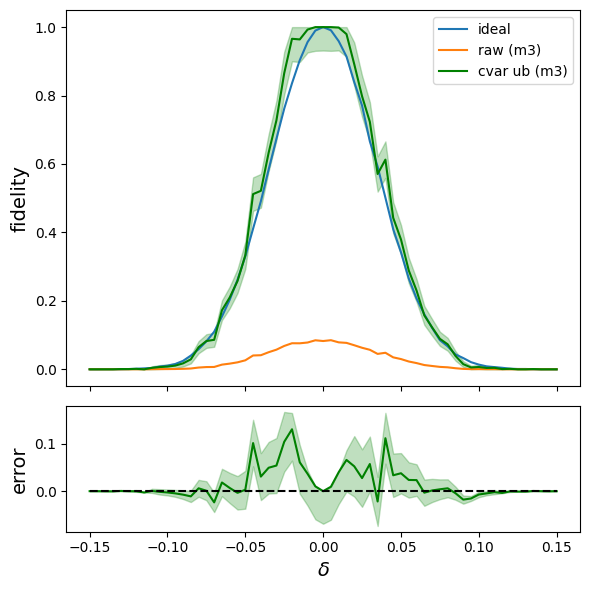

In [26]:
# determine confidence interval
cvar_lb = []
cvar_ub = []
for p in hw_mit_values:
    cvar = min([1, p / fidelity])
    sigma_p = np.sqrt(p*(1-p))
    c = 1.96  # corresponds to 95% confidence interval
    l = max([0, min([1, cvar - c*sigma_p/fidelity/np.sqrt(hw_shots)])])
    u = max([0, min([1, cvar + c*sigma_p/fidelity/np.sqrt(hw_shots)])])
    cvar_lb += [l]
    cvar_ub += [u]

# plot estmated values with confidence intervals and raw data
plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6, 6), sharex=True)
plt.subplot(2,1,1)
plt.plot(deltas, values, label='ideal')
plt.plot(deltas, hw_mit_values, label='raw (m3)')
plt.fill_between(deltas, cvar_lb, cvar_ub, color='green', alpha=0.25)
plt.plot(deltas, cvar_ub_m3_values, label='cvar ub (m3)', color='green')
plt.legend()
# plt.xlabel(r'$\delta$', fontsize=14)
plt.ylabel(r'fidelity', fontsize=14)

# evaluate errors
plt.subplot(2,1,2)
plt.fill_between(deltas, np.array(cvar_lb) - values, np.array(cvar_ub) - values, color='green', alpha=0.25)
plt.plot(deltas, np.array(cvar_ub_m3_values) - values, 'g-')
plt.plot(deltas, 0*deltas, 'k--')
plt.xlabel(r'$\delta$', fontsize=14)
plt.ylabel(r'error', fontsize=14)

plt.tight_layout()
plt.savefig(f'results/figure_2_{backend.name}_{num_qubits}_qubits_{hw_shots}_shots.pdf')
plt.show()

# Figure 3

In [27]:
# define objective to fit EPLG to noise-free data
def objective(e, values=values, quasis=quasis, num_cnots=transpiled_qcs[0].count_ops()['ecr']):
    fidelity = (1 - e)**num_cnots
    fitted_values = []
    for i in range(len(deltas)):
        zero_probs = (quasis[i].get('0'*num_qubits, 0) + quasis[i + len(deltas)].get('0'*num_qubits, 0))/2        
        fitted_values += [min([1, zero_probs / fidelity])]
    lse = np.linalg.norm(np.array(values) - np.array(fitted_values))
    return lse

In [28]:
# fit EPLG to noise-free data
EPLG_fitted = fminbound(objective, EPLG/2, 2*EPLG)
EPLG_fitted

0.012508091660556634

In [29]:
# compute fitted fidelity (= alpha)
fitted_fidelity = (1 - EPLG_fitted)**num_cnots
fitted_fidelity

0.0848349767027192

In [30]:
# evaluate values for fitted EPLG
fitted_values = []
for i in range(len(deltas)):
    zero_probs = (quasis[i].get('0'*num_qubits, 0) + quasis[i + len(deltas)].get('0'*num_qubits, 0))/2
    fitted_values += [min([1, zero_probs / fitted_fidelity])]

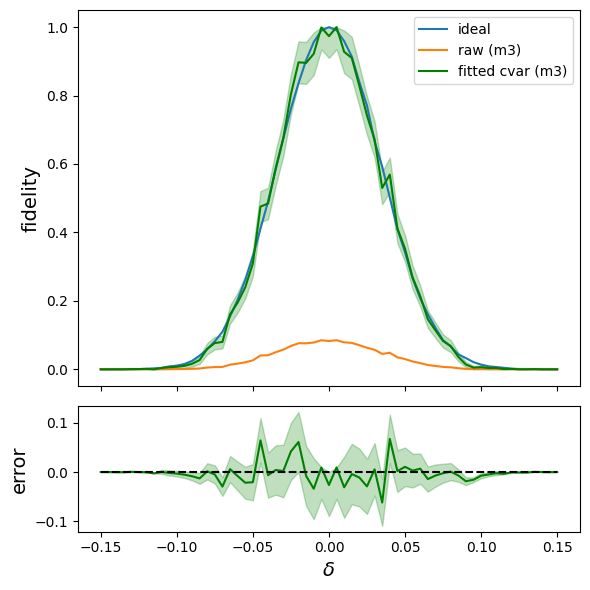

In [31]:
# determine confidence interval
fitted_cvar_lb = []
fitted_cvar_ub = []
for p in hw_mit_values:
    cvar = min([1, p / fitted_fidelity])
    sigma_p = np.sqrt(p*(1-p))
    c = 1.96  # corresponds to 95% confidence interval
    l = max([0, min([1, cvar - c*sigma_p/fitted_fidelity/np.sqrt(hw_shots)])])
    u = max([0, min([1, cvar + c*sigma_p/fitted_fidelity/np.sqrt(hw_shots)])])
    fitted_cvar_lb += [l]
    fitted_cvar_ub += [u]

# plot estmated values with confidence intervals and raw data
plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6, 6), sharex=True)
plt.subplot(2,1,1)
plt.plot(deltas, values, label='ideal')
plt.plot(deltas, hw_mit_values, label='raw (m3)')
plt.fill_between(deltas, fitted_cvar_lb, fitted_cvar_ub, color='green', alpha=0.25)
plt.plot(deltas, fitted_values, label='fitted cvar (m3)', color='green')
plt.legend()
# plt.xlabel(r'$\delta$', fontsize=14)
plt.ylabel(r'fidelity', fontsize=14)

# evaluate errors
plt.subplot(2,1,2)
plt.fill_between(deltas, np.array(fitted_cvar_lb) - values, np.array(fitted_cvar_ub) - values, color='green', alpha=0.25)
plt.plot(deltas, np.array(fitted_values) - values, 'g-')
plt.plot(deltas, 0*deltas, 'k--')
plt.xlabel(r'$\delta$', fontsize=14)
plt.ylabel(r'error', fontsize=14)

plt.tight_layout()
plt.savefig(f'results/figure_3_{backend.name}_{num_qubits}_qubits_{hw_shots}_shots.pdf')
plt.show()